## Imports

In [2]:
!pip install lmdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 1.1 MB/s eta 0:00:00


In [3]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import os
from functools import partial

from IPython.display import clear_output
from tqdm import tqdm

In [4]:
!git clone https://github.com/NVlabs/denoising-diffusion-gan.git ddgan
!touch ddgan/datasets_prep/__init__.py
!touch ddgan/__init__.py

import sys
sys.path.append('/content/')
sys.path.append('/content/ddgan')

Cloning into 'ddgan'...
remote: Enumerating objects: 120, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 120 (delta 2), reused 2 (delta 2), pack-reused 101
Receiving objects: 100% (120/120), 83.07 MiB | 24.23 MiB/s, done.
Resolving deltas: 100% (21/21), done.


In [5]:
from ddgan.EMA import EMA
from ddgan.train_ddgan import Diffusion_Coefficients, Posterior_Coefficients,\
                              get_time_schedule, q_sample_pairs, sample_posterior,\
                              sample_from_model, extract

In [6]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

## Data generation

In [7]:
from sklearn.utils import check_random_state

def my_swiss_roll(n_samples=100, *, noise=0.0, phi_min=1.5*np.pi, phi_max=4.5*np.pi, r_min=5.0, r_max=15.0, random_state=None):
    generator = check_random_state(random_state)
    assert phi_max > phi_min
    assert r_max > r_min

    t = generator.uniform(size=n_samples)
    phi = t * (phi_max - phi_min) + phi_min
    r = t * (r_max - r_min) + r_min

    res = generator.randn(n_samples, 2,) * noise
    res[:, 0] += r * np.cos(phi)
    res[:, 1] += r * np.sin(phi)

    return res

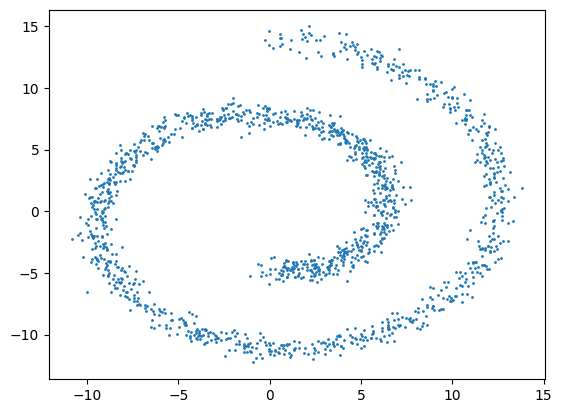

In [8]:
n_samples = 1500
noise = 0.5
X = my_swiss_roll(
    n_samples, noise=noise,
    phi_min=1.5*np.pi, phi_max=4.5*np.pi, r_min=1.5*np.pi, r_max=4.5*np.pi,
)

plt.scatter(X[:, 0], X[:, 1], s=1)

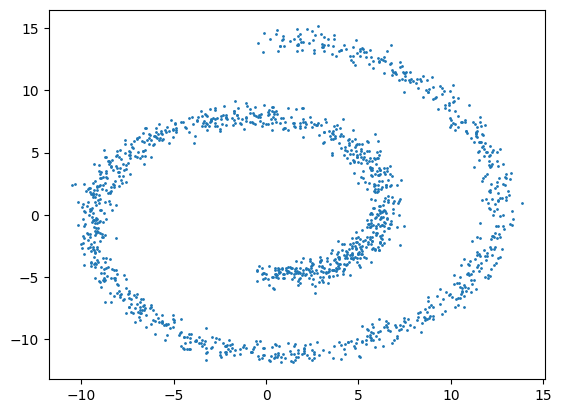

In [9]:
from sklearn.datasets import make_swiss_roll

n_samples = 1500
noise = 0.5
X, _ = make_swiss_roll(n_samples, noise=noise)

plt.scatter(X[:, 0], X[:, 2], s=1)

[]

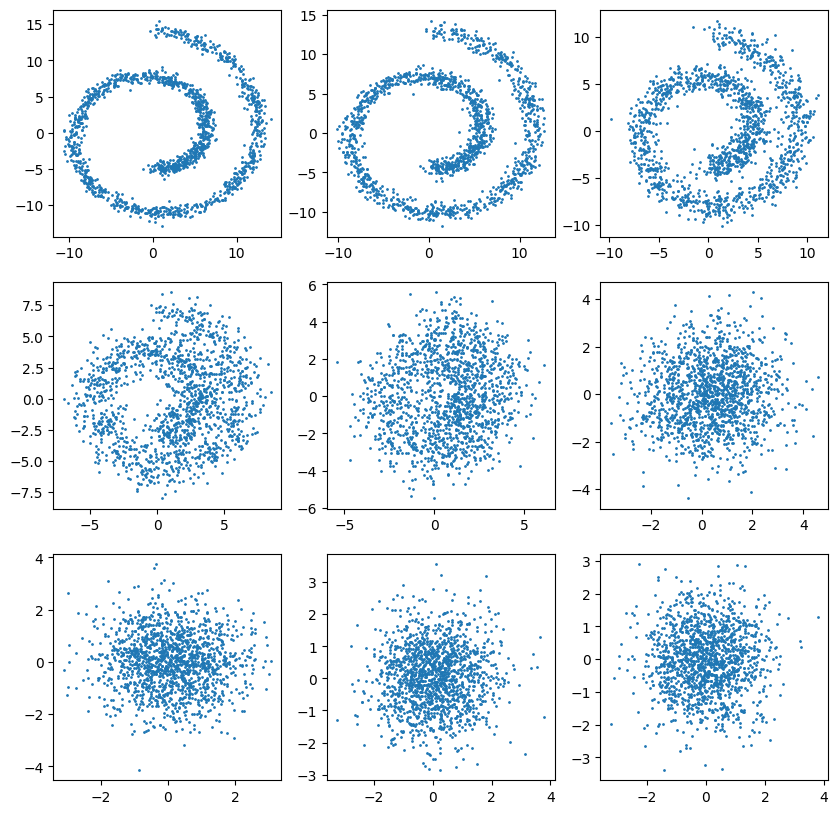

In [18]:
k = 3

args = {
    'num_timesteps': k * k - 1,
    'beta_min': 0.1,
    'beta_max': 20.,
}
args = dotdict(args)

n_samples = 1500
noise = 0.5
X = my_swiss_roll(
    n_samples, noise=noise,
    phi_min=1.5*np.pi, phi_max=4.5*np.pi, r_min=1.5*np.pi, r_max=4.5*np.pi,
)
X = torch.from_numpy(X)
plt.figure(figsize=(10, 10))
plt.subplot(k, k, 1)
plt.scatter(X[:, 0], X[:, 1], s=1)
coeff = Diffusion_Coefficients(args, 'cpu')

#sample t
for i in range(args.num_timesteps):
    t = torch.zeros(X.size(0), dtype=torch.int64) + i

    x_t, x_tp1 = q_sample_pairs(coeff, X, t)

    plt.subplot(k, k, i + 2)
    plt.scatter(x_tp1[:, 0], x_tp1[:, 1], s=1)

plt.plot()

In [11]:
from sklearn.utils import check_random_state

def my_k2_gaussian(n_samples=100, *, noise=1.0, k=3, random_state=None):
    generator = check_random_state(random_state)

    return generator.randint(0, k, size=(n_samples, 2)) + generator.randn(n_samples, 2,) * noise

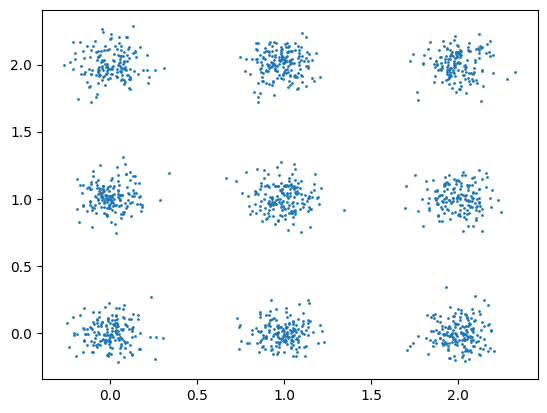

In [20]:
n_samples = 1500
noise = 0.1
X = my_k2_gaussian(
    n_samples, noise=noise, k = 3,
)

plt.scatter(X[:, 0], X[:, 1], s=1)

[]

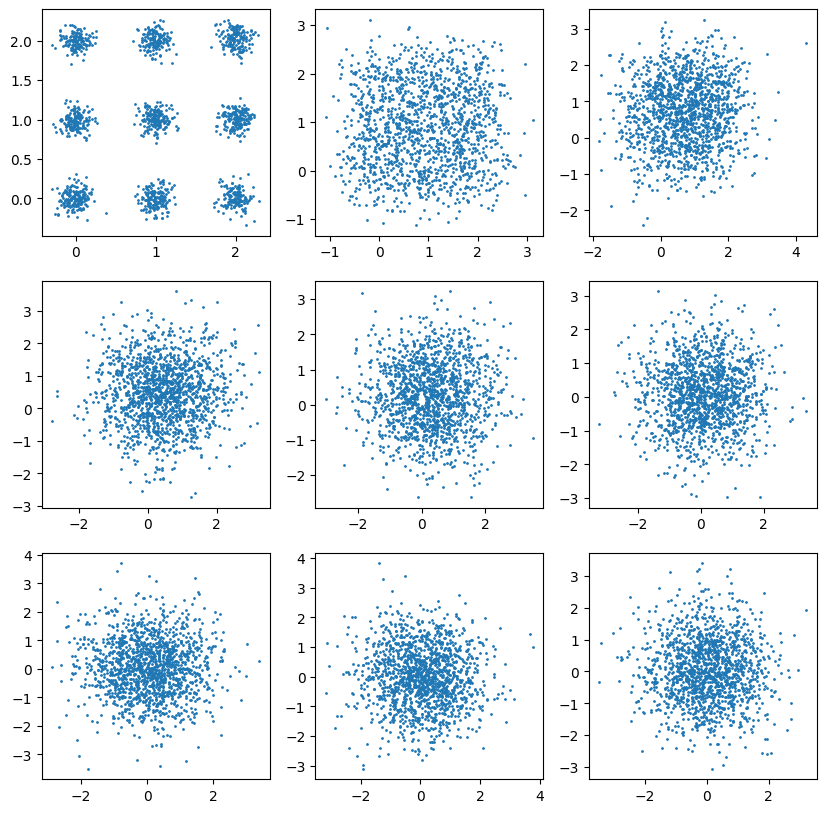

In [17]:
k = 3

args = {
    'num_timesteps': k * k - 1,
    'beta_min': 0.1,
    'beta_max': 20.,
}
args = dotdict(args)

n_samples = 1500
noise = 0.1
X = my_k2_gaussian(
    n_samples, noise=noise, k = 3,
)

X = torch.from_numpy(X)
plt.figure(figsize=(10, 10))
plt.subplot(k, k, 1)
plt.scatter(X[:, 0], X[:, 1], s=1)
coeff = Diffusion_Coefficients(args, 'cpu')

#sample t
for i in range(args.num_timesteps):
    t = torch.zeros(X.size(0), dtype=torch.int64) + i

    x_t, x_tp1 = q_sample_pairs(coeff, X, t)

    plt.subplot(k, k, i + 2)
    plt.scatter(x_tp1[:, 0], x_tp1[:, 1], s=1)

plt.plot()

## Models

У авторов в аппендиксе описаны эксперименты с 25 Gaussian, в которых у них простые генератор и дискриминатор в виде MLP c тремя слоями c `hidden_size = 512`. Для зависимости от `t` они конкатенировали `x/x_t/x_tp1` с `t`. Повторил предложенную архитектуру здесь, по умолчанию поставил `hidden_size` поменьше

In [32]:
class MyGenerator(nn.Module):
    def __init__(
        self, x_dim=2, t_dim=2, n_t=4, z_dim=1, out_dim=2, layers=[128, 128, 128],
        active=partial(nn.LeakyReLU, 0.2),
    ):
        super().__init__()

        self.x_dim = x_dim
        self.t_dim = t_dim
        self.z_dim = z_dim

        self.model = []
        ch_prev = x_dim + t_dim + z_dim

        self.t_transform = nn.Embedding(n_t, t_dim,)

        for ch_next in layers:
            self.model.append(nn.Linear(ch_prev, ch_next))
            self.model.append(active())
            ch_prev = ch_next

        self.model.append(nn.Linear(ch_prev, out_dim))
        self.model = nn.Sequential(*self.model)

    def forward(self, x, t, z):
        batch_size = x.shape[0]

        if z.shape != (batch_size, self.z_dim):
            z = z.reshape((batch_size, self.z_dim))

        return self.model(
            torch.cat([
                x,
                self.t_transform(t),
                z,
            ], dim=1)
        )

class MyDiscriminator(nn.Module):
    def __init__(
        self, x_dim=2, t_dim=2, n_t=4, layers=[128, 128, 128],
        active=partial(nn.LeakyReLU, 0.2),
    ):
        super().__init__()

        self.x_dim = x_dim
        self.t_dim = t_dim

        self.model = []
        ch_prev = 2 * x_dim + t_dim

        self.t_transform = nn.Embedding(n_t, t_dim,)

        for ch_next in layers:
            self.model.append(nn.Linear(ch_prev, ch_next))
            self.model.append(active())
            ch_prev = ch_next

        self.model.append(nn.Linear(ch_prev, 1))
        self.model = nn.Sequential(*self.model)

    def forward(self, x_t, t, x_tp1,):
        return self.model(
            torch.cat([
                x_t,
                self.t_transform(t),
                x_tp1,
            ], dim=1)
        ).squeeze()

## Loss function

### Теор рассуждения:

Во-первых, обучаем две сетки генератор и дискриминатор. Их задачи оптимизации противоположны:

\begin{equation}
\operatorname{argmax}_\phi \mathbb{E}_{x \sim Latent} D_\psi(G_\phi(x)) \\
\operatorname{argmax}_\psi \mathbb{E}_{y \sim Real} D_\psi(y) - \mathbb{E}_{x \sim Latent} D_\psi(G_\phi(x)) \\
\end{equation}

или

\begin{equation}
\operatorname{argmax}_\phi \mathbb{E}_{x \sim Latent} \log D_\psi(G_\phi(x)) \\
\operatorname{argmax}_\psi \mathbb{E}_{y \sim Real} \log D_\psi(y) + \mathbb{E}_{x \sim Latent} \log (1 - D_\psi(G_\phi(x))) \\
\end{equation}

Интуиция: хотим, чтобы дискриминатор хорошо различал реальные и сгенерированные изображения, и хотим, чтобы генератор успешно обманывал дискриминатор

В нашем случае оптимизационная задача в точности выглядит так (скрин из статьи):

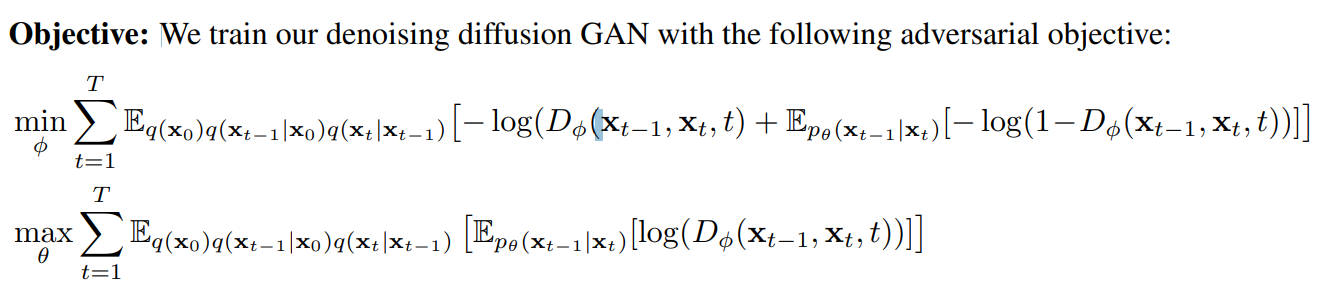




Помимо этого, у дискриминатора также есть следующий регуляризационный член:

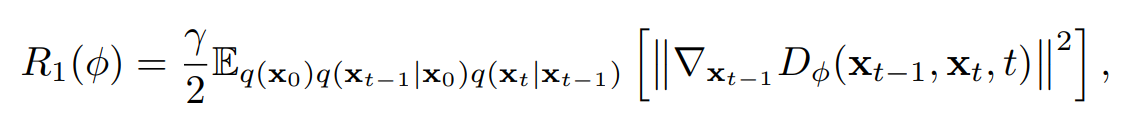

Насколько я понял, он взят из статьи 2018 года, где было объяснено, что этот и другой аналогичный ему $R_2$-коэффициент позволяют GANу обучаться более стабильно на основе идей с равновесием Нэша (?), но до конца идею я не понял

#### Про сам процесс генерации

$q$ и $p_\theta$ - настоящее распределение и распределение, полученное из модели. Формально они определяются следующим образом ($p_\theta$ будет чуть позже)

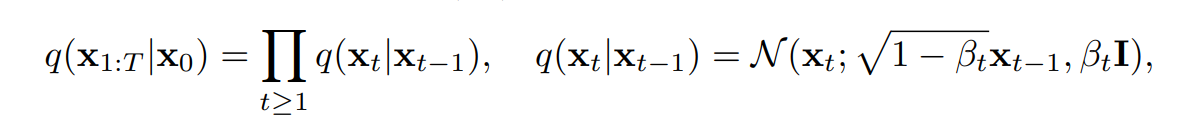

Насколько я знаю, это супер стандартная модель диффузии, ее в таком виде и применяют везде

Ниже есть небольшой комментарий из аппендикса, где авторы выводят все параметры апостериорного распределения для необходимого в последствии $q(x_{t-1}|x_t, x_0)$

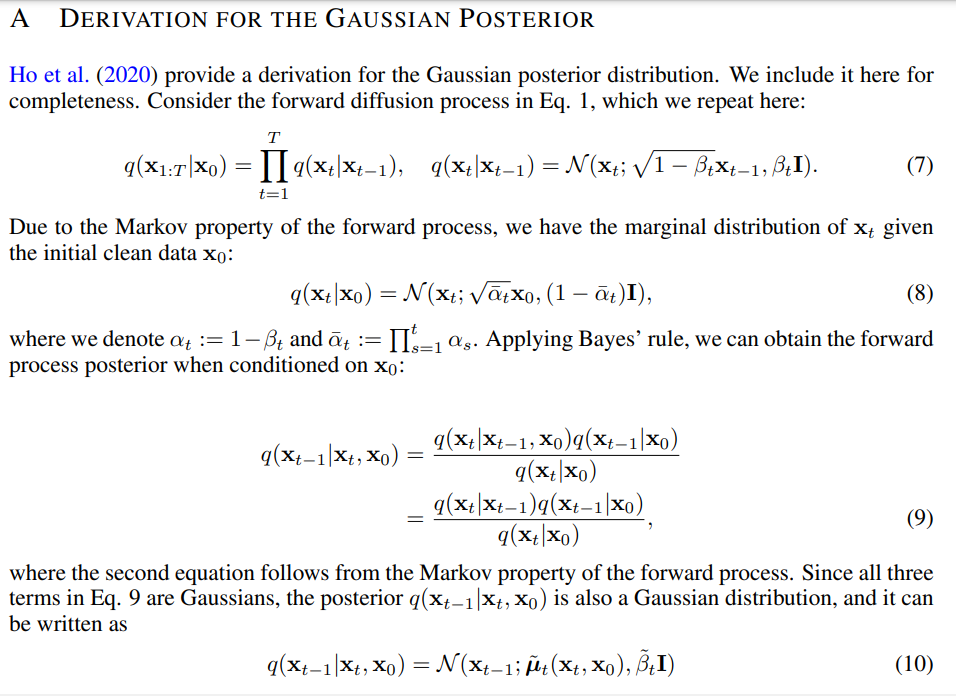

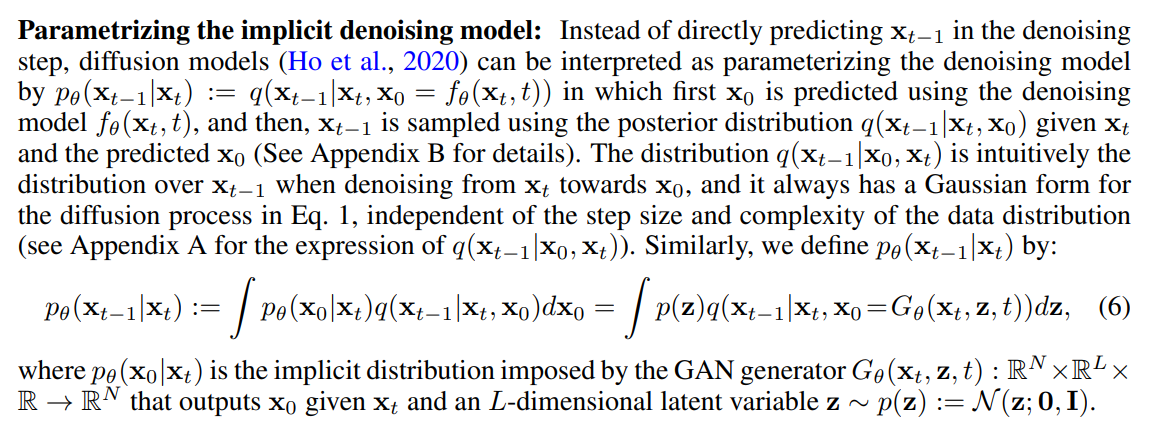

Итого:
1. У нас есть реальное распределение на данных $q(x_{t-1}|x_t)$
2. Мы хотим его приблизить с помощью некоторого $p_\theta(x_{t-1}|x_t)$
3. Но мы делаем это немного иначе, определяя $p_\theta(x_{t-1}|x_t) = q(x_{t-1}|x_t, x_0 = f_\theta(x_t, t))$, где $f_\theta(x_t, t)$ и есть наша генеративная модель

Получается, что вместо стандартной схемы генерации:

$$x_T \overset{gen.}{\rightarrow} x_{T-1}  \overset{gen.}{\rightarrow} \dots \overset{gen.}{\rightarrow}  x_1 \overset{gen.}{\rightarrow} x_0$$

мы делаем $$x_T \overset{gen.}{\rightarrow} x_0^T \overset{diff.}{\rightarrow} x_{T-1}^T  \overset{gen.}{\rightarrow} x_0^{T - 1} \overset{diff.}{\rightarrow} \dots \overset{diff.}{\rightarrow} x_1^2 \overset{gen.}{\rightarrow} x_0^1 \overset{diff.}{\rightarrow} x_0^0 = \hat{x}_0$$

Проще говоря, каждый раз из более лучшего приближения пытаемся сгенерировать результат целиком

Затем поверх этого мы навешиваем, с одной стороны, оптимизационную задачу GANов, с другой, обучаем по принципу диффузионок, с генерацией случайной временной метки и попыткой сгенерировать выход из нее

Авторы также говорят, что они пытались использовать стандартную схему (т.е. просто генерацию в несколько шагов с помощью ганов), но результаты получались значительно хуже


## Training functions

In [33]:
import warnings

class EMA(optim.Optimizer):
    def __init__(self, opt, ema_decay):
        self.ema_decay = ema_decay
        self.apply_ema = self.ema_decay > 0.
        self.optimizer = opt
        self.state = opt.state
        self.param_groups = opt.param_groups

    def step(self, *args, **kwargs):
        retval = self.optimizer.step(*args, **kwargs)

        # stop here if we are not applying EMA
        if not self.apply_ema:
            return retval

        ema, params = {}, {}
        for group in self.optimizer.param_groups:
            for i, p in enumerate(group['params']):
                if p.grad is None:
                    continue
                state = self.optimizer.state[p]

                # State initialization
                if 'ema' not in state:
                    state['ema'] = p.data.clone()

                if p.shape not in params:
                    params[p.shape] = {'idx': 0, 'data': []}
                    ema[p.shape] = []

                params[p.shape]['data'].append(p.data)
                ema[p.shape].append(state['ema'])

            for i in params:
                params[i]['data'] = torch.stack(params[i]['data'], dim=0)
                ema[i] = torch.stack(ema[i], dim=0)
                ema[i].mul_(self.ema_decay).add_(params[i]['data'], alpha=1. - self.ema_decay)

            for p in group['params']:
                if p.grad is None:
                    continue
                idx = params[p.shape]['idx']
                self.optimizer.state[p]['ema'] = ema[p.shape][idx, :]
                params[p.shape]['idx'] += 1

        return retval

    def load_state_dict(self, *args,**kwargs):
        self.optimizer.load_state_dict(*args, **kwargs)
        self.state = self.optimizer.state
        self.param_groups = self.optimizer.param_groups

    def state_dict(self, *args, **kwargs):
        return self.optimizer.state_dict(*args, **kwargs)

    def swap_parameters_with_ema(self, store_params_in_ema):
        """ This function swaps parameters with their ema values. It records original parameters in the ema
        parameters, if store_params_in_ema is true."""

        # stop here if we are not applying EMA
        if not self.apply_ema:
            warnings.warn('swap_parameters_with_ema was called when there is no EMA weights.')
            return

        for group in self.optimizer.param_groups:
            for i, p in enumerate(group['params']):
                if not p.requires_grad:
                    continue
                ema = self.optimizer.state[p]['ema']
                if store_params_in_ema:
                    tmp = p.data.detach()
                    p.data = ema.detach()
                    self.optimizer.state[p]['ema'] = tmp
                else:
                    p.data = ema.detach()

In [34]:
class MySampler:
    def __init__(self, batch_size, sample_func=my_swiss_roll, precalc=None):
        self.precalc = precalc
        self.batch_size = batch_size
        self.sample_func = sample_func

        if self.precalc is not None:
            self.regenerate()

    def regenerate(self):
        self.generated = self.sample_func(self.precalc * self.batch_size,)
        self.idx = 0

    def sample(self):
        if self.precalc is None:
            return self.sample_func(self.batch_size,)
        if self.idx == self.precalc:
            self.regenerate()
        ret = self.generated[self.idx * self.batch_size: (self.idx + 1) * self.batch_size]
        self.idx += 1
        return ret

In [35]:
def sample_posterior(coefficients, x_0,x_t, t):

    def q_posterior(x_0, x_t, t):
        mean = (
            extract(coefficients.posterior_mean_coef1, t, x_t.shape) * x_0
            + extract(coefficients.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        var = extract(coefficients.posterior_variance, t, x_t.shape)
        log_var_clipped = extract(coefficients.posterior_log_variance_clipped, t, x_t.shape)
        return mean, var, log_var_clipped


    def p_sample(x_0, x_t, t):
        mean, _, log_var = q_posterior(x_0, x_t, t)

        noise = torch.randn_like(x_t)

        nonzero_mask = (1 - (t == 0).type(torch.float32))
        while len(nonzero_mask.shape) < len(mean.shape):
            nonzero_mask = nonzero_mask.unsqueeze(-1)

        return mean + nonzero_mask * torch.exp(0.5 * log_var) * noise

    sample_x_pos = p_sample(x_0, x_t, t)

    return sample_x_pos

In [36]:
def sample_from_model(coefficients, generator, n_time, x_init, T, opt):
    x = x_init
    with torch.no_grad():
        for i in reversed(range(n_time)):
            t = torch.full((x.size(0),), i, dtype=torch.int64).to(x.device)

            t_time = t
            latent_z = torch.randn(x.size(0), opt.nz, device=x.device)
            x_0 = generator(x, t_time, latent_z)
            x_new = sample_posterior(coefficients, x_0, x, t)
            x = x_new.detach()

    return x

In [37]:
def train_model(args):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    batch_size = args.batch_size
    nz = args.nz #latent dimension

    netG = MyGenerator(
        x_dim = args.x_dim,
        t_dim = args.t_dim,
        n_t = args.num_timesteps,
        out_dim = args.out_dim,
        z_dim = nz,
        layers = args.layers_G
    ).to(device)

    netD = MyDiscriminator(
        x_dim = args.x_dim,
        t_dim = args.t_dim,
        n_t = args.num_timesteps,
        layers = args.layers_D
    ).to(device)

    optimizerD = optim.Adam(netD.parameters(), lr=args.lr_d, betas = (args.beta1, args.beta2))
    optimizerG = optim.Adam(netG.parameters(), lr=args.lr_g, betas = (args.beta1, args.beta2))

    if args.use_ema:
        optimizerG = EMA(optimizerG, ema_decay=args.ema_decay)

    schedulerG = torch.optim.lr_scheduler.CosineAnnealingLR(optimizerG, args.num_iterations, eta_min=1e-5)
    schedulerD = torch.optim.lr_scheduler.CosineAnnealingLR(optimizerD, args.num_iterations, eta_min=1e-5)

    coeff = Diffusion_Coefficients(args, device)
    pos_coeff = Posterior_Coefficients(args, device)
    T = get_time_schedule(args, device)

    global_iteration, init_iteration = 0, 0
    if args.resume:
        checkpoint_file = os.path.join(args.exp_path, 'content.pth')
        checkpoint = torch.load(checkpoint_file, map_location=device)
        init_iteration = checkpoint['iteration']
        global_iteration = init_iteration

        # load G
        netG.load_state_dict(checkpoint['netG_dict'])
        optimizerG.load_state_dict(checkpoint['optimizerG'])
        schedulerG.load_state_dict(checkpoint['schedulerG'])

        # load D
        netD.load_state_dict(checkpoint['netD_dict'])
        optimizerD.load_state_dict(checkpoint['optimizerD'])
        schedulerD.load_state_dict(checkpoint['schedulerD'])

        print("=> loaded checkpoint (iteration {})"
                  .format(init_iteration))

    sampler = MySampler(
        batch_size=args.batch_size,
        sample_func=args.sample_func,
        precalc=args.precalc,
    )
    history = {
        'D_loss': [],
        'G_loss': [],
    }
    history = dotdict(history)

    for iteration in tqdm(range(init_iteration, args.num_iterations + 1)):
        #########################
        # Discriminator training
        #########################
        for p in netD.parameters():
            p.requires_grad = True

        netD.zero_grad()

        ###################################
        # Sample real data
        x_real = sampler.sample()
        real_data = torch.from_numpy(x_real).to(torch.float32).to(device, non_blocking=True)

        ###################################
        # Sample timesteps
        t = torch.randint(0, args.num_timesteps, (real_data.size(0),), device=device)

        x_t, x_tp1 = q_sample_pairs(coeff, real_data, t)
        x_t.requires_grad = True

        ###################################
        # Optimizing loss on real data
        D_real = netD(x_t, t, x_tp1.detach()).view(-1)

        errD_real = F.softplus(-D_real)
        errD_real = errD_real.mean()

        errD_real.backward(retain_graph=True)

        ###################################
        # R_1(\phi) regularization
        if args.lazy_reg is None or iteration % args.lazy_reg == 0:
            grad_real = torch.autograd.grad(
                outputs=D_real.sum(), inputs=x_t, create_graph=True,
            )[0]
            grad_penalty = (
                grad_real.view(grad_real.size(0), -1).norm(2, dim=1) ** 2
            ).mean()

            grad_penalty = args.r1_gamma / 2 * grad_penalty
            grad_penalty.backward()

        ###################################
        # Sample vector from latent space
        # for generation
        latent_z = torch.randn(batch_size, nz, device=device)

        ###################################
        # Sample fake output
        # (x_tp1 -> x_0 -> x_t)
        x_0_predict = netG(x_tp1.detach(), t, latent_z)
        x_pos_sample = sample_posterior(pos_coeff, x_0_predict, x_tp1, t)

        ###################################
        # Optimize loss on fake data
        output = netD(x_pos_sample, t, x_tp1.detach()).view(-1)

        errD_fake = F.softplus(output)
        errD_fake = errD_fake.mean()
        errD_fake.backward()

        errD = errD_real + errD_fake

        history.D_loss.append(errD.item())

        ###################################
        # Update weights of netD
        optimizerD.step()

        #############################################################

        #########################
        # Generator training
        #########################
        for p in netD.parameters():
            p.requires_grad = False
        netG.zero_grad()

        ###################################
        # Sample timesteps
        t = torch.randint(0, args.num_timesteps, (real_data.size(0),), device=device)

        ###################################
        # Sample pairs for training
        x_t, x_tp1 = q_sample_pairs(coeff, real_data, t)

        ###################################
        # Sample vector from latent space
        # for generation
        latent_z = torch.randn(batch_size, nz, device=device)

        ###################################
        # Sample fake output
        # (x_tp1 -> x_0 -> x_t)
        x_0_predict = netG(x_tp1.detach(), t, latent_z)
        x_pos_sample = sample_posterior(pos_coeff, x_0_predict, x_tp1, t)

        ###################################
        # Optimize loss on fake data
        output = netD(x_pos_sample, t, x_tp1.detach()).view(-1)

        ###################################
        # Update weights of netG
        errG = F.softplus(-output)
        errG = errG.mean()

        errG.backward()
        optimizerG.step()
        history.G_loss.append(errG.item())

        # LR-Scheduling step
        schedulerG.step()
        schedulerD.step()

        if args.visualize and (iteration + 1) % args.visualize_every == 0:
            x_t_1 = torch.randn_like(real_data)
            x_fake = sample_from_model(pos_coeff, netG, args.num_timesteps, x_t_1, T, args).detach().cpu().numpy()

            clear_output(wait=True)
            plt.figure(figsize=(10, 8))
            plt.subplot(2, 2, 1)
            plt.plot(history.G_loss)
            plt.title('Generator loss')

            plt.subplot(2, 2, 3)
            plt.plot(history.D_loss)
            plt.title('Discriminator loss')

            plt.subplot(2, 2, 4)
            plt.scatter(x_real[:, 0], x_real[:, 1], s=1, label='real')
            plt.legend()
            plt.gca().set_aspect('equal', adjustable='box')
            xlim = plt.gca().get_xlim()
            ylim = plt.gca().get_ylim()

            plt.subplot(2, 2, 2)
            plt.scatter(x_fake[:, 0], x_fake[:, 1], s=1, label='fake')
            plt.title('Visualization')
            plt.gca().set_aspect('equal', adjustable='box')
            plt.gca().set_xlim(xlim)
            plt.gca().set_ylim(ylim)
            plt.legend()

            plt.show()

        if args.print and (iteration + 1) % args.print_every == 0:
            print('iteration: {} | G Loss: {} | D Loss: {}'.format(iteration, errG.item(), errD.item()))

        if args.exp_path is not None and args.save_content and (iteration + 1) % args.save_content_every == 0:
            print('Saving content.')
            content = {
                'iteration': iteration,
                # 'args': args,
                'netG_dict': netG.state_dict(),
                'optimizerG': optimizerG.state_dict(),
                'schedulerG': schedulerG.state_dict(),
                'netD_dict': netD.state_dict(),
                'optimizerD': optimizerD.state_dict(),
                'schedulerD': schedulerD.state_dict(),
            }

            torch.save(content, os.path.join(args.exp_path, 'content.pth'))

        if args.save_ckpt and args.exp_path is not None and (iteration + 1) % args.save_ckpt_every == 0:
            if args.use_ema:
                optimizerG.swap_parameters_with_ema(store_params_in_ema=True)

            torch.save(netG.state_dict(), os.path.join(args.exp_path, 'netG_{}.pth'.format(iteration)))
            torch.save(netD.state_dict(), os.path.join(args.exp_path, 'netD_{}.pth'.format(iteration)))
            if args.use_ema:
                optimizerG.swap_parameters_with_ema(store_params_in_ema=True)

    if args.save_ckpt and args.exp_path is not None:
        # Save model in the end
        if args.use_ema:
            optimizerG.swap_parameters_with_ema(store_params_in_ema=True)

        torch.save(netG.state_dict(), os.path.join(args.exp_path, 'netG_final.pth'))
        torch.save(netD.state_dict(), os.path.join(args.exp_path, 'netD_final.pth'))

        if args.use_ema:
            optimizerG.swap_parameters_with_ema(store_params_in_ema=True)

## Swiss roll experiment

#### Hyperparameters

БОльшая часть параметров перекочевала из их репозитория, некоторые были немного адаптированы

In [ ]:
args = {
    'nz': 1,
    'num_timesteps': 4,
    'x_dim': 2,
    't_dim': 2,
    'out_dim': 2,
    'beta_min': 0.1,
    'beta_max': 20.,
    'layers_G': [256, 256, 256],
    'layers_D': [256, 256, 256],
    'num_iterations': 200000,
    'batch_size': 512,
    'lr_d': 1e-4,
    'lr_g': 1e-4,
    'beta1': 0.5,
    'beta2': 0.9,
    'r1_gamma': 0.01,
    'lazy_reg': 1,
    'use_ema': True,
    'ema_decay': 0.999,
    'sampler_precalc': 1000,
    'sampler_gen_params':{},
    'sample_func': partial(
        my_swiss_roll,
        noise=0.5,
        phi_min=1.5 * np.pi,
        phi_max=6.5 * np.pi,
        r_min=2,
        r_max=20,
    ),
    'exp_path': "./swiss_roll/",
    'save_ckpt':True,
    'save_ckpt_every': 5000,
    'save_content':True,
    'save_content_every': 5000,
    'visualize':True,
    'visualize_every': 1000,
    'print': True,
    'print_every': 100,
    'resume': False,
}
args = dotdict(args)

In [ ]:
!rm -rf $args.exp_path
!mkdir $args.exp_path

#### Training

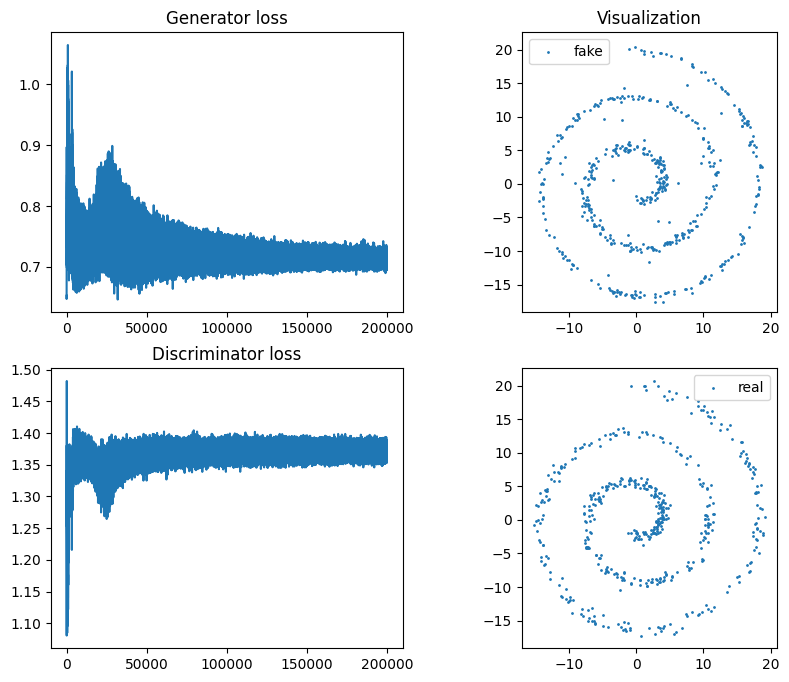

100%|██████████| 200001/200001 [43:05<00:00, 77.35it/s]

iteration: 199999 | G Loss: 0.7239131331443787 | D Loss: 1.3655774593353271
Saving content.


In [ ]:
train_model(args)

#### Visualization

In [ ]:
def visualize_generation(args, model_name=None, batch_size=None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    if batch_size is None:
        batch_size = args.batch_size

    nz = args.nz #latent dimension

    netG = MyGenerator(
        x_dim = args.x_dim,
        t_dim = args.t_dim,
        n_t = args.num_timesteps,
        out_dim = args.out_dim,
        z_dim = nz,
        layers = args.layers_G
    ).to(device)

    if model_name is None:
        model_name = "netG_final.pth"

    checkpoint_file = os.path.join(args.exp_path, model_name)
    checkpoint = torch.load(checkpoint_file, map_location=device)
    netG.load_state_dict(checkpoint)

    coeff = Diffusion_Coefficients(args, device)
    pos_coeff = Posterior_Coefficients(args, device)
    T = get_time_schedule(args, device)

    netG.eval()
    with torch.no_grad():
        x_t_1 = torch.randn((batch_size, args.x_dim)).to(device)
        x_fake = sample_from_model(pos_coeff, netG, args.num_timesteps, x_t_1, T, args).detach().cpu().numpy()
    x_real = args.sample_func(batch_size)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.scatter(x_real[:, 0], x_real[:, 1], s=1, label='real')
    plt.legend()
    plt.gca().set_aspect('equal', adjustable='box')
    xlim = plt.gca().get_xlim()
    ylim = plt.gca().get_ylim()

    plt.subplot(1, 2, 2)
    plt.scatter(x_fake[:, 0], x_fake[:, 1], s=1, label='fake')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.gca().set_xlim(xlim)
    plt.gca().set_ylim(ylim)
    plt.legend()
    plt.suptitle('Visualization')

    plt.show()

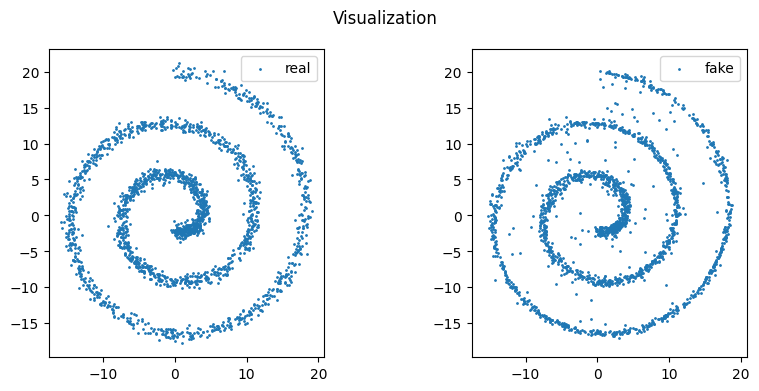

In [ ]:
visualize_generation(args, batch_size=2048)

In [ ]:
def sample_from_model_with_trajectory(coefficients, generator, n_time, x_init, T, opt, sample_latent=True):
    x = x_init
    traj = {
        'x_init': x_init.detach().cpu().numpy(),
        'x_0s': [],
        'xs': [],
    }
    with torch.no_grad():
        for i in reversed(range(n_time)):
            t = torch.full((x.size(0),), i, dtype=torch.int64).to(x.device)

            t_time = t
            latent_z = torch.zeros(x.size(0), device=x.device)
            if sample_latent:
                latent_z = torch.randn(x.size(0), opt.nz, device=x.device)
            x_0 = generator(x, t_time, latent_z)
            x_new = sample_posterior(coefficients, x_0, x, t)
            x = x_new.detach()
            traj['x_0s'].append(x_0.detach().cpu().numpy())
            traj['xs'].append(x.detach().cpu().numpy())

    traj['x'] = x.detach().cpu().numpy()
    return traj

In [ ]:
def visualize_trajectories(args, model_name=None, batch_size=None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    if batch_size is None:
        batch_size = args.batch_size

    nz = args.nz #latent dimension

    netG = MyGenerator(
        x_dim = args.x_dim,
        t_dim = args.t_dim,
        n_t = args.num_timesteps,
        out_dim = args.out_dim,
        z_dim = nz,
        layers = args.layers_G
    ).to(device)

    if model_name is None:
        model_name = "netG_final.pth"

    checkpoint_file = os.path.join(args.exp_path, model_name)
    checkpoint = torch.load(checkpoint_file, map_location=device)
    netG.load_state_dict(checkpoint)

    coeff = Diffusion_Coefficients(args, device)
    pos_coeff = Posterior_Coefficients(args, device)
    T = get_time_schedule(args, device)

    netG.eval()
    with torch.no_grad():
        x_t_1 = torch.randn((batch_size, args.x_dim)).to(device)
        traj = sample_from_model_with_trajectory(pos_coeff, netG, args.num_timesteps, x_t_1, T, args)
    x_real = args.sample_func(batch_size)

    plt.figure(figsize=(20, 8))
    plt.subplot(2, 5, 1)
    plt.scatter(traj['x_init'][:, 0], traj['x_init'][:, 1], s=1)
    plt.title("Step 0: Get random " + r"$x_T = \hat{" + f"x_4" + "}$")
    plt.xlim(-20, 22)
    plt.ylim(-20, 22)

    k = 2
    for x in traj['xs']:
        plt.subplot(2, 5, k)
        plt.scatter(x[:, 0], x[:, 1], s=1)
        plt.xlim(-20, 22)
        plt.ylim(-20, 22)
        plt.title(f"Step {2 * (k - 1)}: sample " + r"$\hat{" + f"x_{5 - k}" + "}$" + " from " + r"$\hat{" + f"x_0^{6 - k}" + "}$")
        k += 1

    for x_0 in traj['x_0s']:
        plt.subplot(2, 5, k)
        plt.scatter(x_0[:, 0], x_0[:, 1], s=1,)
        plt.xlim(-20, 22)
        plt.ylim(-20, 22)
        plt.title(f"Step {2 * k - 11}: generate " + r"$\hat{" + f"x_0^{10 - k}" + "}$" + " from " + r"$\hat{" + f"x_{10 - k}" + "}$")

        k += 1

    plt.suptitle('Trajectories')

    plt.show()

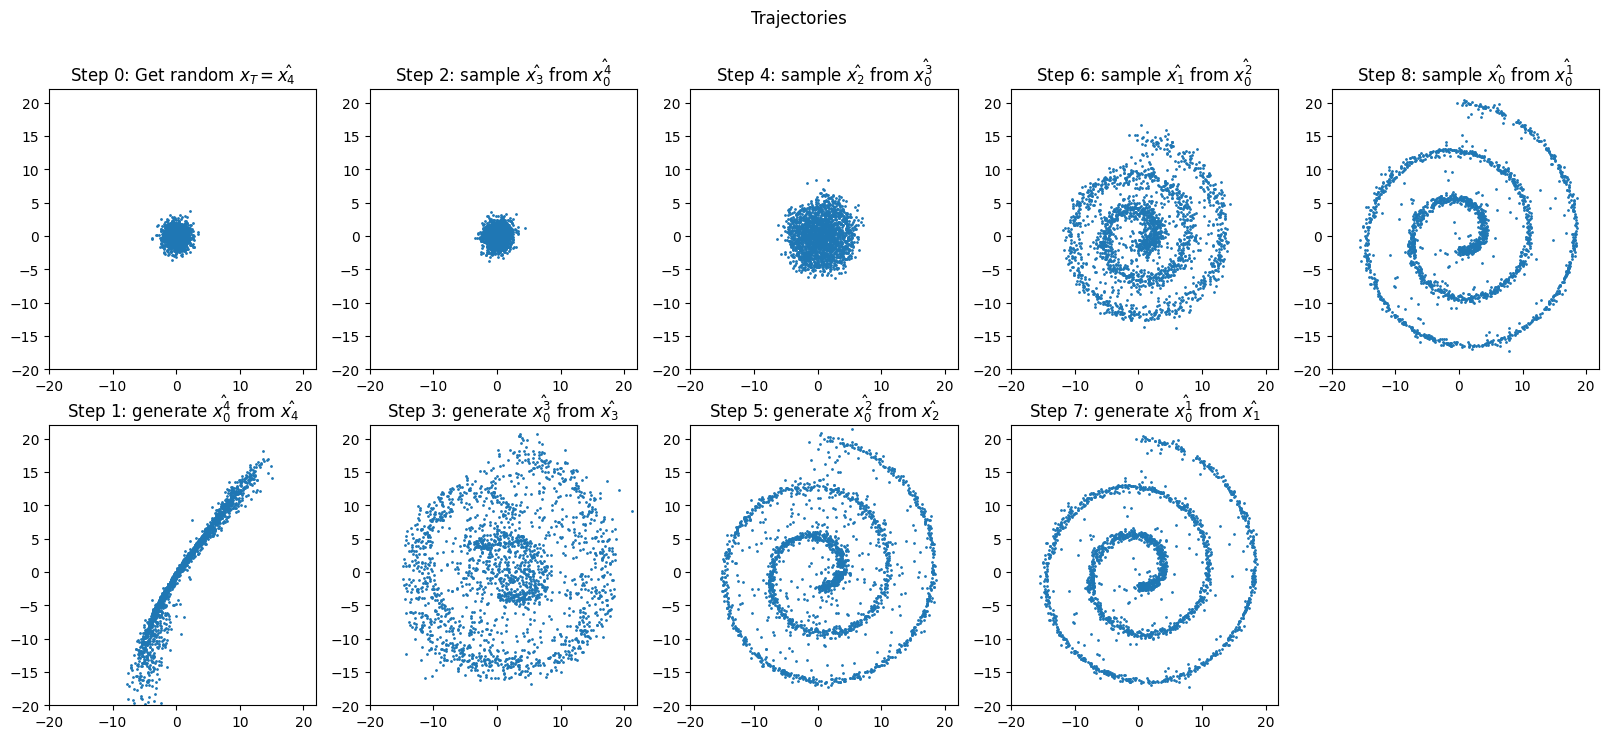

In [ ]:
visualize_trajectories(args, batch_size=2048)

## N-Gaussian experiment

#### Hyperparameters

БОльшая часть параметров перекочевала из их репозитория, некоторые были немного адаптированы

In [38]:
args = {
    'nz': 1,
    'num_timesteps': 4,
    'x_dim': 2,
    't_dim': 2,
    'out_dim': 2,
    'beta_min': 0.1,
    'beta_max': 20.,
    'layers_G': [256, 256, 256],
    'layers_D': [256, 256, 256],
    'num_iterations': 200000,
    'batch_size': 512,
    'lr_d': 1e-4,
    'lr_g': 1e-4,
    'beta1': 0.5,
    'beta2': 0.9,
    'r1_gamma': 0.01,
    'lazy_reg': 1,
    'use_ema': True,
    'ema_decay': 0.999,
    'sampler_precalc': 1000,
    'sampler_gen_params':{},
    'sample_func': partial(
        my_k2_gaussian,
        noise=0.1,
        k=3,
    ),
    'exp_path': "./n_gaussian/",
    'save_ckpt':True,
    'save_ckpt_every': 5000,
    'save_content':True,
    'save_content_every': 5000,
    'visualize':True,
    'visualize_every': 1000,
    'print': True,
    'print_every': 100,
    'resume': False,
}
args = dotdict(args)

In [39]:
!rm -rf $args.exp_path
!mkdir $args.exp_path

#### Training

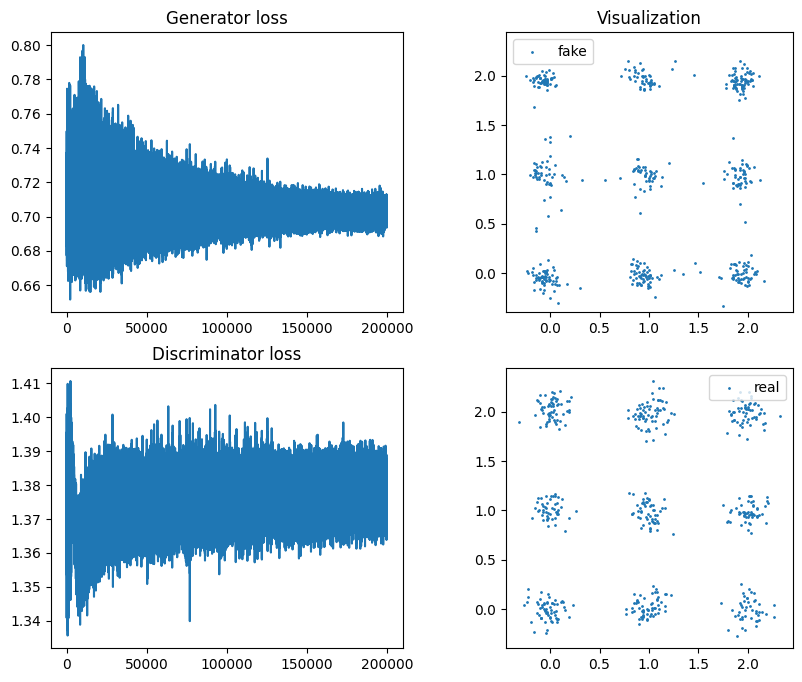

100%|██████████| 200001/200001 [41:27<00:00, 80.42it/s]

iteration: 199999 | G Loss: 0.701958954334259 | D Loss: 1.3714196681976318
Saving content.


In [40]:
train_model(args)

#### Visualization

In [41]:
def visualize_generation(args, model_name=None, batch_size=None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    if batch_size is None:
        batch_size = args.batch_size

    nz = args.nz #latent dimension

    netG = MyGenerator(
        x_dim = args.x_dim,
        t_dim = args.t_dim,
        n_t = args.num_timesteps,
        out_dim = args.out_dim,
        z_dim = nz,
        layers = args.layers_G
    ).to(device)

    if model_name is None:
        model_name = "netG_final.pth"

    checkpoint_file = os.path.join(args.exp_path, model_name)
    checkpoint = torch.load(checkpoint_file, map_location=device)
    netG.load_state_dict(checkpoint)

    coeff = Diffusion_Coefficients(args, device)
    pos_coeff = Posterior_Coefficients(args, device)
    T = get_time_schedule(args, device)

    netG.eval()
    with torch.no_grad():
        x_t_1 = torch.randn((batch_size, args.x_dim)).to(device)
        x_fake = sample_from_model(pos_coeff, netG, args.num_timesteps, x_t_1, T, args).detach().cpu().numpy()
    x_real = args.sample_func(batch_size)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.scatter(x_real[:, 0], x_real[:, 1], s=1, label='real')
    plt.legend()
    plt.gca().set_aspect('equal', adjustable='box')
    xlim = plt.gca().get_xlim()
    ylim = plt.gca().get_ylim()

    plt.subplot(1, 2, 2)
    plt.scatter(x_fake[:, 0], x_fake[:, 1], s=1, label='fake')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.gca().set_xlim(xlim)
    plt.gca().set_ylim(ylim)
    plt.legend()
    plt.suptitle('Visualization')

    plt.show()

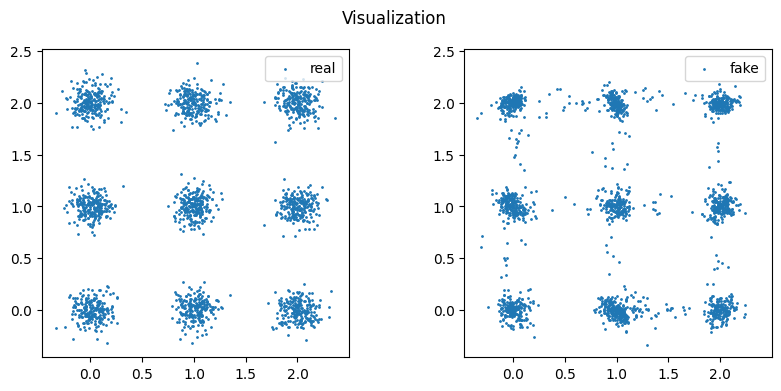

In [42]:
visualize_generation(args, batch_size=2048)

In [43]:
def sample_from_model_with_trajectory(coefficients, generator, n_time, x_init, T, opt, sample_latent=True):
    x = x_init
    traj = {
        'x_init': x_init.detach().cpu().numpy(),
        'x_0s': [],
        'xs': [],
    }
    with torch.no_grad():
        for i in reversed(range(n_time)):
            t = torch.full((x.size(0),), i, dtype=torch.int64).to(x.device)

            t_time = t
            latent_z = torch.zeros(x.size(0), device=x.device)
            if sample_latent:
                latent_z = torch.randn(x.size(0), opt.nz, device=x.device)
            x_0 = generator(x, t_time, latent_z)
            x_new = sample_posterior(coefficients, x_0, x, t)
            x = x_new.detach()
            traj['x_0s'].append(x_0.detach().cpu().numpy())
            traj['xs'].append(x.detach().cpu().numpy())

    traj['x'] = x.detach().cpu().numpy()
    return traj

In [48]:
def visualize_trajectories(args, model_name=None, batch_size=None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    if batch_size is None:
        batch_size = args.batch_size

    nz = args.nz #latent dimension

    netG = MyGenerator(
        x_dim = args.x_dim,
        t_dim = args.t_dim,
        n_t = args.num_timesteps,
        out_dim = args.out_dim,
        z_dim = nz,
        layers = args.layers_G
    ).to(device)

    if model_name is None:
        model_name = "netG_final.pth"

    checkpoint_file = os.path.join(args.exp_path, model_name)
    checkpoint = torch.load(checkpoint_file, map_location=device)
    netG.load_state_dict(checkpoint)

    coeff = Diffusion_Coefficients(args, device)
    pos_coeff = Posterior_Coefficients(args, device)
    T = get_time_schedule(args, device)

    netG.eval()
    with torch.no_grad():
        x_t_1 = torch.randn((batch_size, args.x_dim)).to(device)
        traj = sample_from_model_with_trajectory(pos_coeff, netG, args.num_timesteps, x_t_1, T, args)
    x_real = args.sample_func(batch_size)

    plt.figure(figsize=(20, 8))
    plt.subplot(2, 5, 1)
    plt.scatter(traj['x_init'][:, 0], traj['x_init'][:, 1], s=1)
    plt.title("Step 0: Get random " + r"$x_T = \hat{" + f"x_4" + "}$")
    plt.xlim(-2.5, 2.5)
    plt.ylim(-2.5, 2.5)

    k = 2
    for x in traj['xs']:
        plt.subplot(2, 5, k)
        plt.scatter(x[:, 0], x[:, 1], s=1)
        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.title(f"Step {2 * (k - 1)}: sample " + r"$\hat{" + f"x_{5 - k}" + "}$" + " from " + r"$\hat{" + f"x_0^{6 - k}" + "}$")
        k += 1

    for x_0 in traj['x_0s']:
        plt.subplot(2, 5, k)
        plt.scatter(x_0[:, 0], x_0[:, 1], s=1,)
        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.title(f"Step {2 * k - 11}: generate " + r"$\hat{" + f"x_0^{10 - k}" + "}$" + " from " + r"$\hat{" + f"x_{10 - k}" + "}$")

        k += 1

    plt.suptitle('Trajectories')

    plt.show()

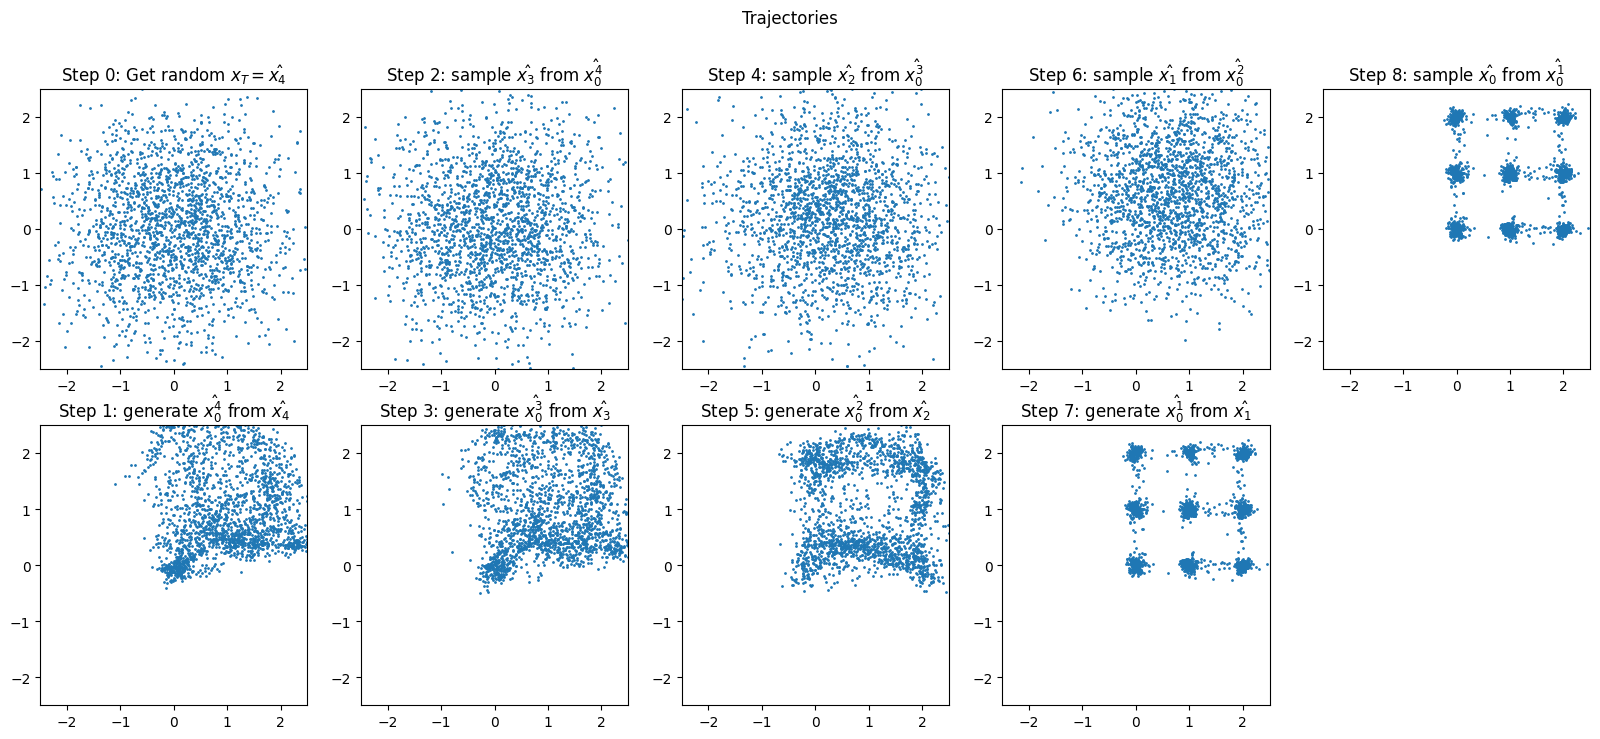

In [49]:
visualize_trajectories(args, batch_size=2048)